In [1]:
import numpy as np
import sys
import os
# sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')
import astropy.io.fits as pf
import matplotlib.pylab as mplot
%pylab inline
import fitsio
import h5py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
metadata = np.genfromtxt('../code/measurement/tile_DR3_1_1_v2.csv', dtype='str', delimiter=",")[1:]
# print(metadata)

In [3]:
Columns = ['dec', 'good_frac', 'id', 
           'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_err_1m',
           'mcal_T_err_1p', 'mcal_T_err_2m', 'mcal_T_err_2p', 'mcal_T_err_noshear',
           'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m',
           'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p',
           'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_cov_1m', 'mcal_flux_cov_1p', 'mcal_flux_cov_2m',
           'mcal_flux_cov_2p', 'mcal_flux_cov_noshear', 'mcal_flux_err_1m', 'mcal_flux_err_1p',
           'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear',
           'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p',
           'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_nfev_1m',
           'mcal_nfev_1p', 'mcal_nfev_2m', 'mcal_nfev_2p', 'mcal_nfev_noshear', 'mcal_pars_1m',
           'mcal_pars_1p', 'mcal_pars_2m', 'mcal_pars_2p', 'mcal_pars_cov_1m', 'mcal_pars_cov_1p',
           'mcal_pars_cov_2m', 'mcal_pars_cov_2p', 'mcal_pars_cov_noshear', 'mcal_pars_noshear',
           'mcal_psf_T_noshear', 'mcal_psf_g_noshear', 'mcal_s2n_1m', 'mcal_s2n_1p', 'mcal_s2n_2m',
           'mcal_s2n_2p', 'mcal_s2n_noshear', 'mcal_s2n_r_1m', 'mcal_s2n_r_1p', 'mcal_s2n_r_2m',
           'mcal_s2n_r_2p', 'mcal_s2n_r_noshear', 'ra', 'x', 'y']

shear_dir = '/project2/chihway/data/decade/shearcat_v1/'
coadd_dir = '/project2/chihway/data/decade/coaddcat_v1/'

path = '/scratch/midway2/chihway/metacal_test_2000tiles_20230214.hdf'
with h5py.File(path, "w") as f:

    #Create all columns you need
    test_tile = metadata[0][0][2:-1]
    test_fits = fitsio.FITS(shear_dir+'metacal_output_'+test_tile+'.fits')
    for col in Columns:
        if col!='ra' and col!='dec':
            Ndim = len(test_fits[1].read(vstorage='object')[col].shape)
            if Ndim==1:
                f.create_dataset(col, data = [], chunks=(10**4,), maxshape = (None,))
            if Ndim==2:
                f.create_dataset(col, data = [[]], chunks=((10**4,10)), maxshape = (None,10))
            if Ndim==3:
                f.create_dataset(col, data = [[[]]], chunks=((10**4,10,10)), maxshape = (None,10,10))

    f.create_dataset('ra', data = [], chunks=(10**4,), maxshape = (None,))            
    f.create_dataset('dec', data = [], chunks=(10**4,), maxshape = (None,))            

    #Helper function. Just improves readability
    #Appends new_data array into existing dataset
    def add_data(dataset, new_data):

        dataset.resize(dataset.shape[0] + len(new_data), axis=0)
        dataset[-len(new_data):] = new_data


    for i in range(2000):
        tile = metadata[i][0][2:-1]

        if os.path.exists(shear_dir+'metacal_output_'+tile+'.fits') and os.path.exists(coadd_dir+'gold_mask_'+tile+'.npz'):
            fits = fitsio.FITS(shear_dir+'metacal_output_'+tile+'.fits')
 
            shear_cat = fits[1].read(vstorage='object')
            # metacal output files, it has an ID that is the correct coadd IDs, but already 
            # with a cut that only includes objects that have a metacal measurement

            shear_id = np.load(shear_dir+'ids_match_'+tile+'.npz', allow_pickle=True)
            # ad hoc file we save when running metacal, the full list of coadd IDs for all objects in the MEDS file
            # these are row-by-row matched to the catalog files that contain e.g. photometry

            gold_mask = np.load(coadd_dir+'gold_mask_'+tile+'.npz', allow_pickle=True)
            gold_mask_full = gold_mask['maskSE']*gold_mask['maskIMA']*(gold_mask['maskSG']>=2) 
            # from the catalog files, we make the gold cut
            # still using rough star/galaxy separation

            shear_id_masked_gold = shear_id['ids'][gold_mask_full]
            # this is IDs of all the objects that pass the gold cut

            mask_joint = np.in1d(shear_cat['id'], shear_id_masked_gold)
            # mask to apply on the metacal catalog, to remove objects that don't pass the gold cut

            mask_joint_invert = np.in1d(shear_id_masked_gold, shear_cat['id'][mask_joint])
            # invert mask to apply to the original tile catalog, to selecout the final objects

            ra = gold_mask['ra'][gold_mask_full][mask_joint_invert]
            dec = gold_mask['dec'][gold_mask_full][mask_joint_invert]
            add_data(f['ra'], ra)
            add_data(f['dec'], dec)
            
            for col2 in Columns:
                if col2!='ra' and col2!='dec':
                    data = shear_cat[col2][mask_joint]
                    add_data(f[col2], data)
                    if col2=='id':
                        print(i, len(f[col2]))

        else:
            print('tile missing '+tile)



0 26087
1 42561
2 77891
3 95532
4 109646
5 121217
6 137655
7 158712
8 179589
9 194356
10 225839
11 241625
12 254484
13 267185
14 286536
15 291903
16 310244
17 333757
18 349002
19 364003
20 370942
21 385370
22 406909
23 425657
24 442643
25 459973
26 477738
27 491620
28 510346
29 523788
30 536007
31 548325
32 561486
33 575451
34 590068
35 601422
36 610993
37 624073
38 642302
39 658102
40 671638
41 687162
42 718358
43 736151
44 757794
45 773267
46 782870
47 800571
48 816140
49 830033
50 847258
51 858064
52 878553
53 897038
54 915022
55 929749
56 953420
57 974205
58 989408
59 1010081
60 1027656
61 1039015
62 1052674
63 1073078
64 1089306
65 1100357
66 1114598
67 1116061
68 1133941
69 1151189
70 1164297
71 1175256
72 1184387
73 1198243
74 1215420
75 1233686
76 1254770
77 1269019
78 1276991
79 1302995
80 1324424
81 1336273
82 1349175
83 1354391
84 1372394
85 1387570
86 1404004
87 1419414
88 1431850
89 1449150
90 1464032
91 1484255
92 1499925
93 1512550
94 1532026
95 1547486
96 1560019
97 157

687 11423238
688 11436048
689 11445278
690 11461183
691 11478073
692 11493629
693 11511365
694 11522639
695 11535346
696 11547932
697 11560915
698 11577476
699 11595508
700 11615240
701 11629974
702 11651273
703 11666490
704 11683887
705 11700921
706 11713030
707 11724055
708 11742120
709 11765541
710 11780596
711 11797045
712 11818267
713 11836807
714 11854741
715 11864876
716 11882945
717 11902408
718 11914508
719 11930020
720 11950198
721 11970117
722 11976127
723 11991360
724 11998181
725 12015324
726 12034094
727 12047645
728 12060650
729 12071142
730 12092840
731 12124007
732 12139456
733 12155596
734 12165684
735 12182211
736 12193740
737 12208404
738 12225229
739 12241623
740 12257120
741 12272581
742 12289159
743 12303187
744 12306400
745 12323219
746 12339127
747 12359704
748 12384240
749 12400864
750 12421680
751 12440451
752 12459634
753 12480150
754 12493556
755 12511117
756 12533222
757 12554731
758 12571738
759 12588339
760 12607225
761 12621096
762 12634316
763 12653503

1294 21492982
1295 21508051
1296 21521192
1297 21538325
1298 21562019
1299 21571859
1300 21585713
1301 21608346
1302 21624441
1303 21638955
1304 21653604
1305 21669844
1306 21691640
1307 21706628
1308 21720697
1309 21749337
1310 21765809
1311 21796575
1312 21813246
1313 21835645
1314 21852992
1315 21867703
1316 21884874
1317 21891923
1318 21908489
1319 21911864
1320 21933916
1321 21962138
1322 21980406
1323 21999155
1324 22018620
1325 22034310
1326 22052055
1327 22070098
1328 22086541
1329 22104877
1330 22117634
1331 22129000
1332 22139719
1333 22155589
1334 22176805
1335 22191631
1336 22202755
1337 22218140
tile missing DES1100-0958
1339 22238343
1340 22253157
1341 22282838
1342 22296022
1343 22309018
1344 22320112
1345 22335472
1346 22351851
1347 22368620
1348 22393132
1349 22405402
1350 22417282
1351 22427818
1352 22442558
1353 22461387
1354 22476973
1355 22493755
1356 22499155
1357 22511059
1358 22523052
1359 22536412
1360 22553697
1361 22573039
1362 22590921
1363 22615637
1364 226

1878 31291386
1879 31315833
1880 31329140
1881 31345214
1882 31362008
1883 31380596
1884 31395268
1885 31408542
1886 31424955
1887 31439020
1888 31461830
1889 31478127
1890 31502733
1891 31512589
1892 31533730
1893 31565528
1894 31579237
1895 31600601
1896 31611544
1897 31634299
1898 31652778
1899 31660438
1900 31676581
1901 31697086
tile missing DES1000+0209
1903 31708144
1904 31723023
1905 31741277
1906 31763729
1907 31783226
1908 31794088
1909 31809427
1910 31825887
1911 31852753
1912 31869697
1913 31888623
1914 31909629
1915 31921950
1916 31933560
1917 31954808
1918 31977515
1919 31979449
1920 31981397
1921 32003034
1922 32014275
1923 32029650
1924 32046070
1925 32069109
1926 32086063
1927 32107312
1928 32110423
1929 32123782
1930 32142387
tile missing DES0911-0915
1932 32167662
1933 32184945
1934 32203585
1935 32222492
1936 32232103
1937 32252742
1938 32281991
1939 32313496
1940 32332428
1941 32353087
1942 32369448
1943 32377336
1944 32393023
1945 32406819
1946 32420791
1947 32437

In [36]:
with h5py.File('/scratch/midway2/chihway/metacal_test_2000tiles_20230214.hdf', 'r') as f:
    print(len(f['ra'][:]))
    ra = f['ra'][:]
    dec = f['dec'][:]
    s2n = f['mcal_s2n_noshear'][:]
    T = f['mcal_T_ratio_noshear'][:]
#     print(len(ra[mask]), len(ra[mask])*1.0/(0.5*60*60*2000))

33223888


In [42]:
mask = (T>0.5)

In [43]:
len(mask)

77156459

In [26]:
import healpy as hp

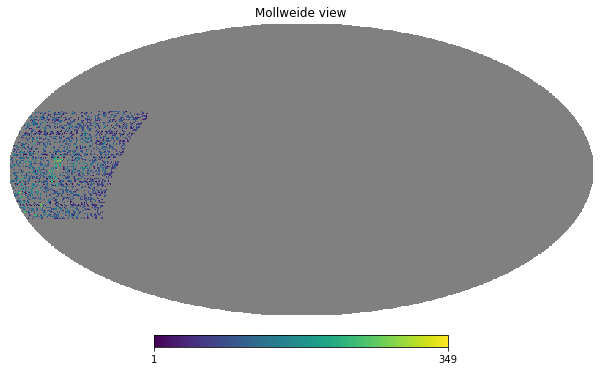

In [27]:
nside = 1024
theta = (90.-dec)/180*np.pi
phi = ra/180*np.pi
pix = hp.ang2pix(nside, theta, phi)
map_shearcat = np.zeros(hp.nside2npix(nside))
for i in range(len(pix)):
    map_shearcat[pix[i]] += 1
    
map_shearcat[map_shearcat==0] = hp.UNSEEN
hp.mollview(map_shearcat)

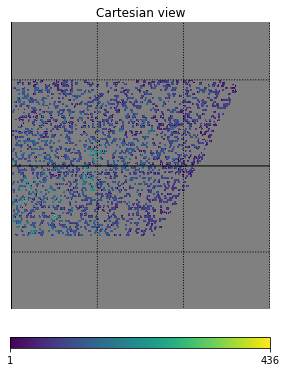

In [28]:
hp.cartview(map_shearcat, lonra=[90,180], latra=[-50,50])
hp.graticule()